In [30]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
def read_benchmark(path):
    dfs = []

    with open(path, 'r') as file:
        for doc in yaml.safe_load_all(file):
            for experiment in doc["experiments"]:
                instance = doc["instance"].split("/")[-1]
                finder = doc["finder"]
                name = experiment["name"]
                iterations = doc["iterations"]
                seed = experiment["seed"]
                dfs.append(pd.DataFrame([[instance, finder, name, iterations, seed, experiment["time_mean"], experiment["time_std"], experiment["count"]]], columns=["instance", "finder", "name", "iterations", "seed", "time_mean", "time_std", "count"]))

    return pd.concat(dfs, ignore_index=True)

In [106]:
def read_metadata(path):
    with open(path, 'r') as file:
        meta = yaml.safe_load(file)
        
    def extract_df(instance_metadata):
        instance = instance_metadata["name"]

        graph = instance_metadata["graph"]
        number_of_vertices = graph["number_of_vertices"]
        number_of_edges = graph["number_of_edges"]
        average_clustering_coefficient = graph["average_clustering_coefficient"]
        complexity = graph["complexity"]
        density = graph["density"]
        number_of_connected_components = graph["number_of_connected_components"]
        
        return pd.DataFrame([
            [ instance,   number_of_vertices,   number_of_edges,   average_clustering_coefficient,   complexity,   density]], columns=
            ["instance", "number_of_vertices", "number_of_edges", "average_clustering_coefficient", "complexity", "density"])

    return pd.concat(map(extract_df, meta), ignore_index=True).set_index("instance")

In [110]:
paths = ['../finder_benchmark_bio_2019-08-30_CenterC4P4.yaml', '../finder_benchmark_bio_2019-08-30_NaiveC4P4.yaml']
df = pd.concat(map(read_benchmark, paths), ignore_index=True)
meta_df = read_metadata('../data/bio/metadata.yaml')
df = df.join(meta_df, on='instance')

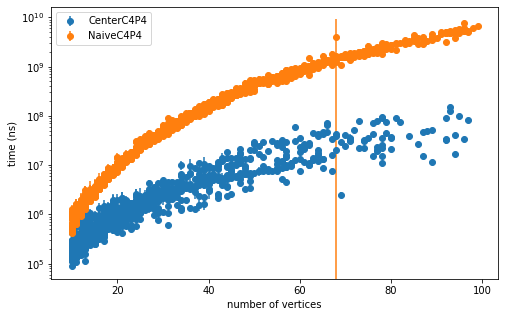

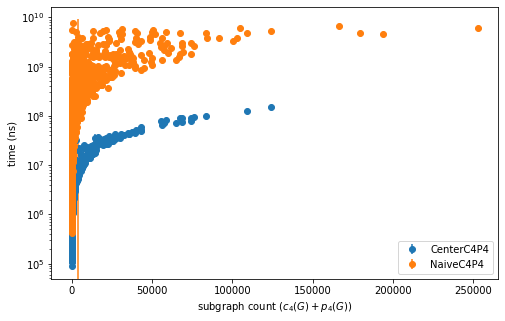

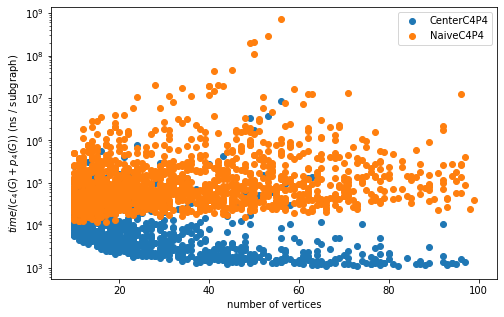

In [124]:
find_all = df[df["name"] == "find all subgraphs"]

def plot_n_time():
    fig, ax = plt.subplots(figsize=(8, 5))

    for finder, group_df in find_all.groupby("finder"):
        x = group_df["number_of_vertices"]
        y = group_df["time_mean"]
        yerr = group_df["time_std"]
        ax.errorbar(x, y, yerr=yerr, fmt='o', label=finder)

    ax.set_yscale('log')
    ax.set_xlabel("number of vertices")
    ax.set_ylabel("time (ns)")
    plt.legend()
    plt.show()


def plot_count_time():
    fig, ax = plt.subplots(figsize=(8, 5))

    for finder, group_df in find_all.groupby("finder"):
        x = group_df["count"]
        y = group_df["time_mean"]
        yerr = group_df["time_std"]
        ax.errorbar(x, y, yerr=yerr, fmt='o', label=finder)

    ax.set_yscale('log')
    ax.set_xlabel("subgraph count ($c_4(G) + p_4(G)$)")
    ax.set_ylabel("time (ns)")
    plt.legend()
    plt.show()

def plot_n_time_per_subgraph():
    fig, ax = plt.subplots(figsize=(8, 5))

    for finder, group_df in find_all.groupby("finder"):
        x = group_df["number_of_vertices"]
        y = group_df["time_mean"] / group_df["count"]
        ax.scatter(x, y, label=finder)

    ax.set_yscale('log')
    ax.set_xlabel("number of vertices")
    ax.set_ylabel("$time / (c_4(G) + p_4(G))$ (ns / subgraph)")
    plt.legend()
    plt.show()

def plot_benchmark(X, Y, xlabel, ylabel, *, yscale='linear'):
    fig, ax = plt.subplots(figsize=(8, 5))

    for finder, group_df in find_all.groupby("finder"):
        x = X(group_df)
        y = Y(group_df)
        ax.scatter(x, y, label=finder)

    ax.set_yscale(yscale)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    plt.show()


plot_n_time()
plot_count_time()
plot_n_time_per_subgraph()

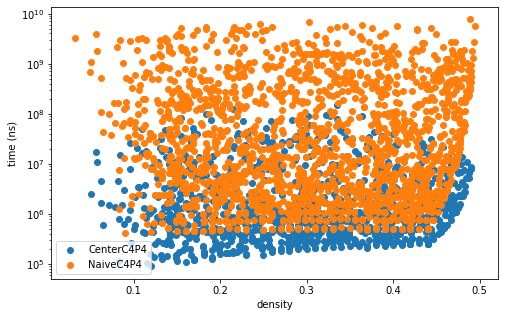

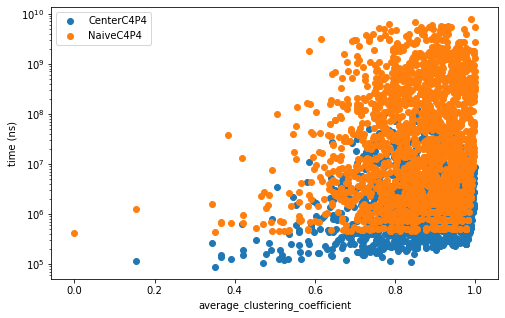

In [127]:
plot_benchmark(lambda df: df['density'], lambda df: df['time_mean'], 'density', 'time (ns)', yscale='log')
plot_benchmark(lambda df: df['average_clustering_coefficient'], lambda df: df['time_mean'], 'average_clustering_coefficient', 'time (ns)', yscale='log')

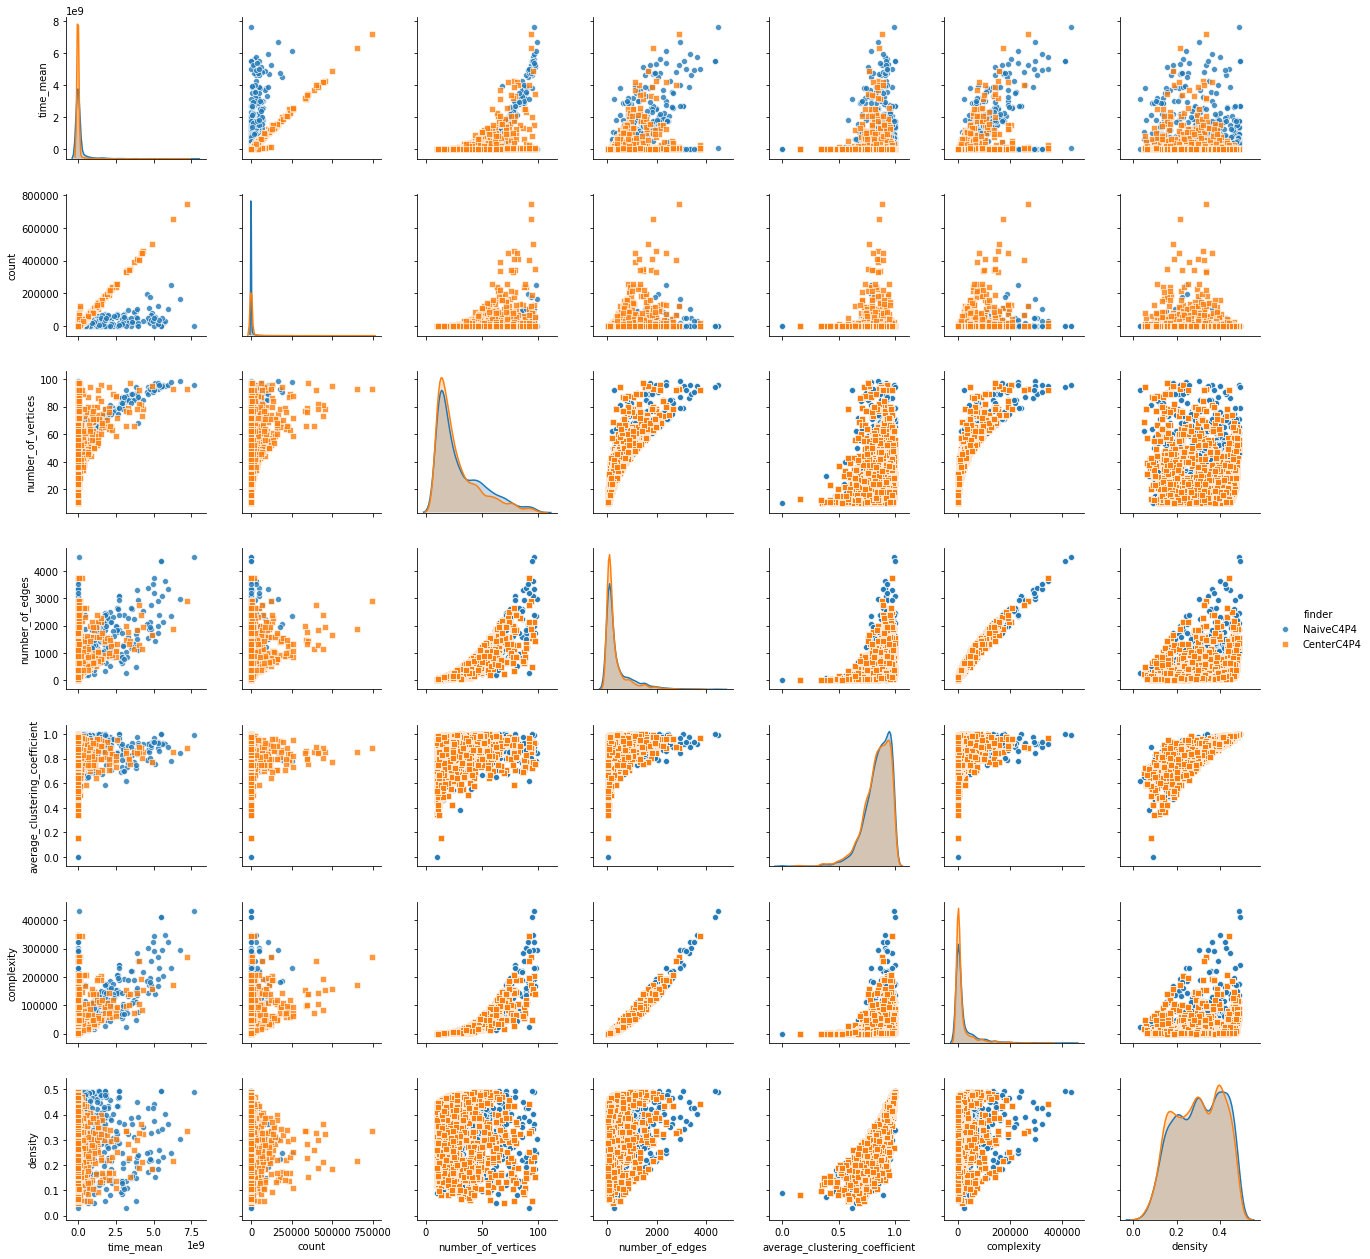

In [143]:
import seaborn as sns

sns.pairplot(df, vars=['time_mean', 'count', 'number_of_vertices', 'number_of_edges',
                 'average_clustering_coefficient', 'complexity', 'density'],
             diag_kind='kde', hue='finder', hue_order=['NaiveC4P4', 'CenterC4P4'], markers=['o', 's'], plot_kws=dict(alpha=0.8))
plt.show()